<a href="https://colab.research.google.com/github/GuillaumeMagnette/Stage_Tritons/blob/master/image_segmentation_u_net_newts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Modules

In [13]:
from google.colab import drive
!rm -rf /content/content
drive.mount('/content/drive')
#!cp '/content/drive/My Drive/slim.zip' slim.zip
!unzip -q /content/drive/"My Drive"/Stage/aug_database_for_seg.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [17]:
#!rm -rf /content/Mask_RCNN/pattern_annotated
!unzip -q /content/pattern_annotated.zip

replace pattern_annotated/Bascha_P01_T01_K03_F_Adult_4265_20190319190818.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
%tensorflow_version 2.x
%matplotlib inline

from os import path                      # os level path manipulation
from glob import glob                    # Unix style pathname pattern expansion
import numpy as np                       # array goodnes
from matplotlib import pyplot as plt     # plotting library
import nibabel as nib                    # handlie NIFTI files
from tqdm import tqdm, trange            # progress bars
from tensorflow.keras.utils import get_file  # handy function to download data

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

# Load Data
The data-set is derived from the Automated Cardiac Diagnosis challenge (ACDC). The data-set provides the following classes for semantic segmentation:

  0. background
  1. right ventricular cavity
  2. left ventricular myocardium
  3. left ventricular cavity

![acdc logo]

## Imaging Technique
> The acquisitions were obtained over a 6 year period using two MRI scanners of different magnetic strengths (1.5 T (Siemens Area, Siemens Medical Solutions, Germany) and 3.0 T (Siemens Trio Tim, Siemens Medical Solutions, Germany)). Cine MR images were acquired in breath hold with a retrospective or prospective gating and with a SSFP sequence in short axis orientation. Particularly, a series of short axis slices cover the LV from the base to the apex, with a thickness of 5 mm (or sometimes 8 mm) and sometimes an interslice gap of 5 mm (then one image every 5 or 10 mm, according to the examination). The spatial resolution goes from 1.37 to 1.68 mm2/pixel and 28 to 40 images cover completely or partially the cardiac cycle (in the second case, with prospective gating, only 5 to 10 % of the end of the cardiac cycle was omitted), all depending on the patient.  
([source][data set information])


[acdc logo]: https://acdc.creatis.insa-lyon.fr/description/files/illustrationChallengeACDC.png
[data set information]: https://acdc.creatis.insa-lyon.fr/description/databases.html

In [2]:
from skimage.transform import resize             # resize images
from skimage.exposure import equalize_adapthist  # CLAHE
from skimage.exposure import rescale_intensity   # used to normalize the image data
from sklearn.model_selection import train_test_split    # helper function to split the data

target_shape = (128, 128)
data_fn = get_file('acdc.tgz', 'https://bitbucket.org/hbwinther/data/downloads/acdc.tgz', extract=True)
basepath = path.split(data_fn)[0]

X, Y = [], []
for fn in tqdm(glob(path.join(basepath, 'img', '*.nii.gz')), desc='pre-processing'):
  root, cn = path.split(fn)

  #load image
  img = nib.load(fn)
  im = img.get_data()
  im = resize(im, target_shape, preserve_range=True)
  im = rescale_intensity(im, 'image', (-1.0, 1.0))
  im = np.expand_dims(im, -1)

  # load mask
  mask = nib.load(path.join(basepath, 'mask', cn))
  ma = mask.get_data().astype(np.uint8)
  ma = resize(ma, target_shape, order=0, preserve_range=True, anti_aliasing=False) # nearest neighbor
  ma_onehot = []
  for cls in [0, 1, 2, 3]:
    ma_onehot.append(ma == cls)
  ma_onehot = np.stack(ma_onehot, axis=-1)

  X.append(im)
  Y.append(ma_onehot)

X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

115261440/115255012 [==============================] - 5s 0us/step


pre-processing:   0%|          | 0/1902 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
pre-processing: 100%|██████████| 1902/1902 [00:21<00:00, 87.21it/s]


In [0]:
def prepare_dataset(dataset_dir, subset):
        """Load a subset of the newts dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val

        then 

        Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """

        image_ids = []
        image_info = []
        # Background is always the first class
        class_info = [{"source": "", "id": 0, "name": "BG"}]
        source_class_ids = {}
        # Add classes. We have only one class to add.
        #self.add_class("newt_pattern", 1, "newt_pattern")
        class_info.append({"newt_pattern", 1, "newt_pattern"})

        # Train or validation dataset?
        #assert subset in ["train", "test"]
        #dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        #/content/images_annotated/via_export_newts.json
        annotations = json.load(open(os.path.join(dataset_dir, "via_export_newts_pattern.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            image_info.append(
                {source = "newt_pattern",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons})
            


       
        # If not a newt dataset image, delegate to parent class.
        #image_info = self.image_info[image_id]
        #if image_info["source"] != "newt_pattern":
        #    return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]

        for info in image_info:

          mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
          for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        
          ma_onehot = []
          for cls in [0, 1]:
          ma_onehot.append(mask == cls)
          ma_onehot = np.stack(ma_onehot, axis=-1)
        #mask[mask == 0] = -1
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

In [37]:
############################################################
#  Dataset
############################################################

class NewtsDataset(utils.Dataset):

    def load_newts(self, dataset_dir, subset):
        """Load a subset of the newts dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("newt_pattern", 1, "newt_pattern")

        # Train or validation dataset?
        #assert subset in ["train", "test"]
        #dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        #/content/images_annotated/via_export_newts.json
        annotations = json.load(open(os.path.join(dataset_dir, "via_export_newts_pattern.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "newt_pattern",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a newt dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "newt_pattern":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        #mask[mask == 0] = -1
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "newt_pattern":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



NameError: ignored

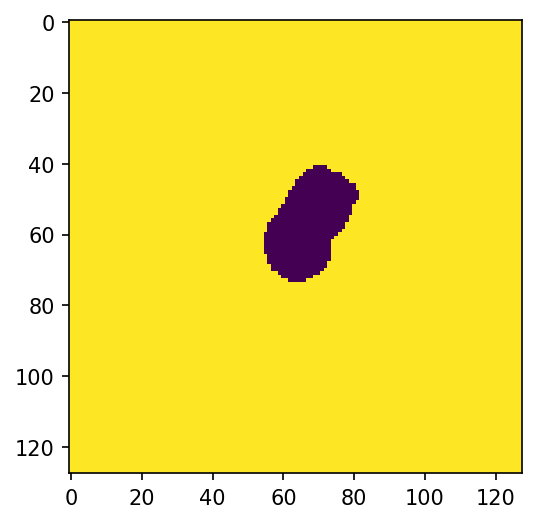

In [44]:
plt.imshow(Y[1,:,:,0])

-1.0


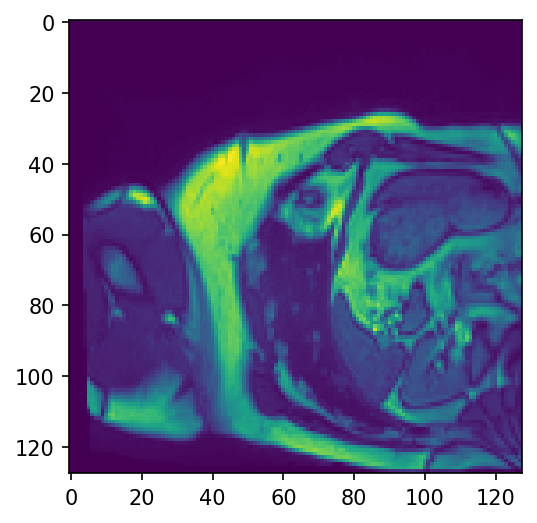

In [41]:
print(np.min(X[5]))
plt.imshow(np.squeeze(X[2]))

# Inspect the Dataset

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

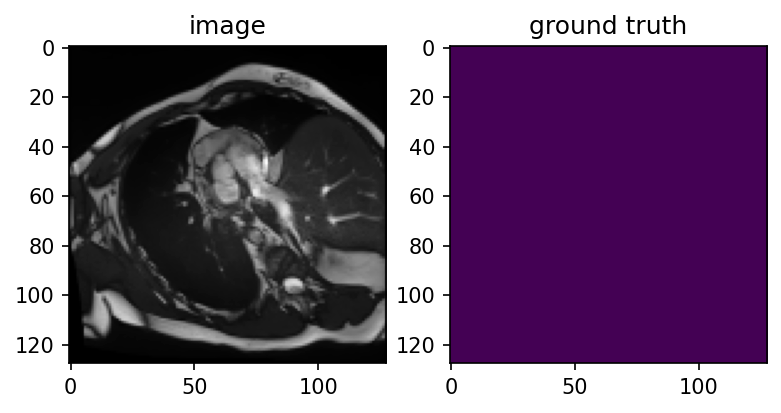

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

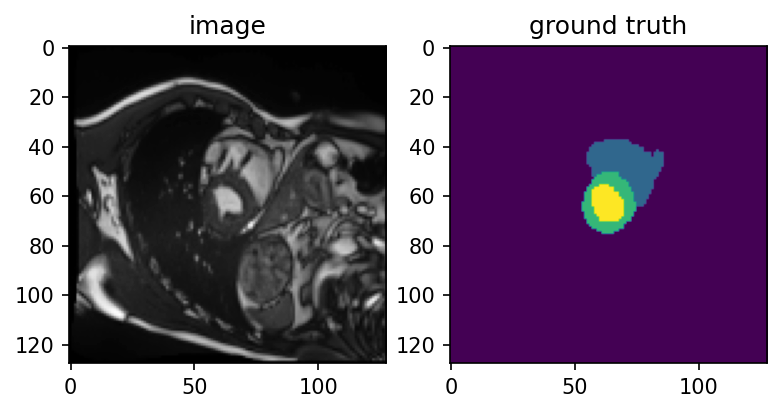

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

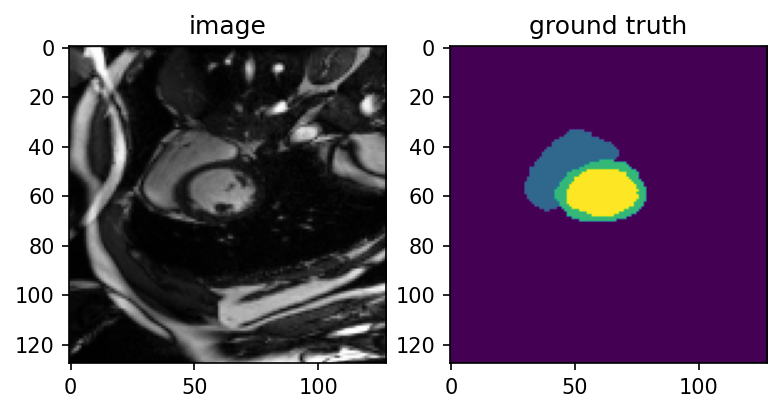

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

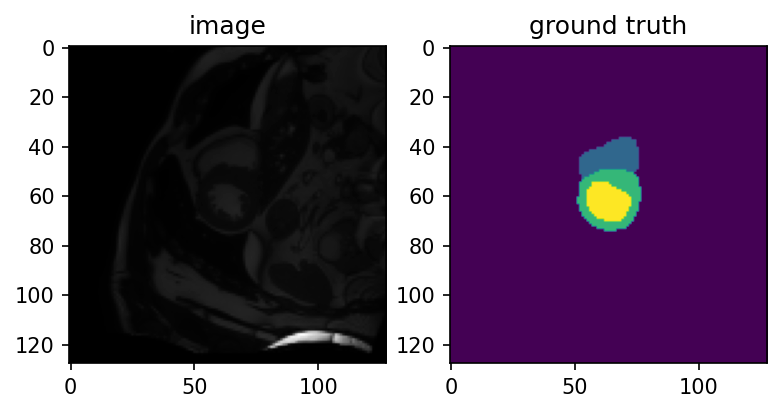

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

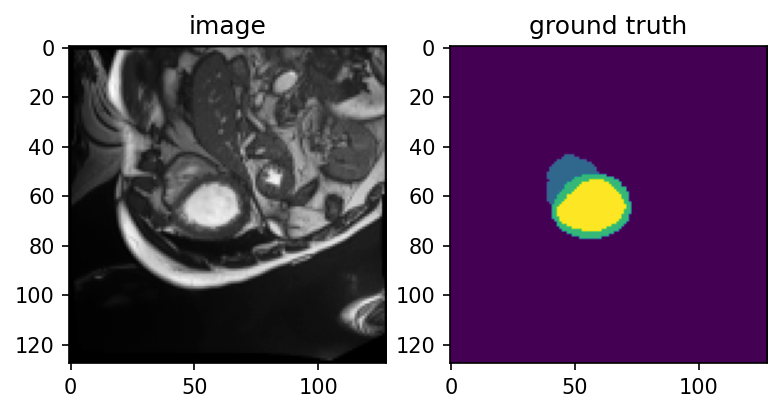

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

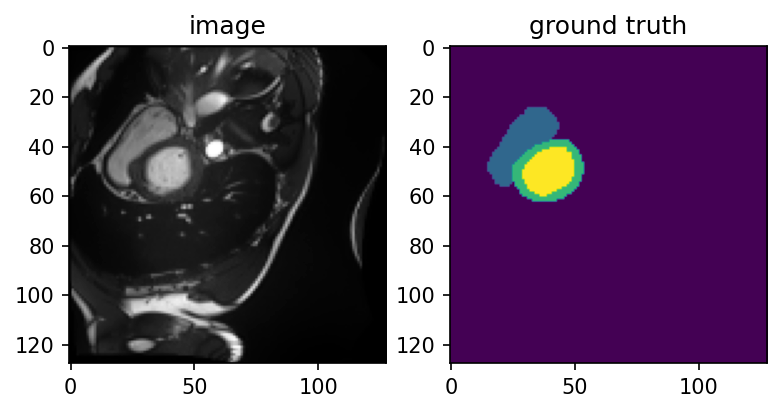

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

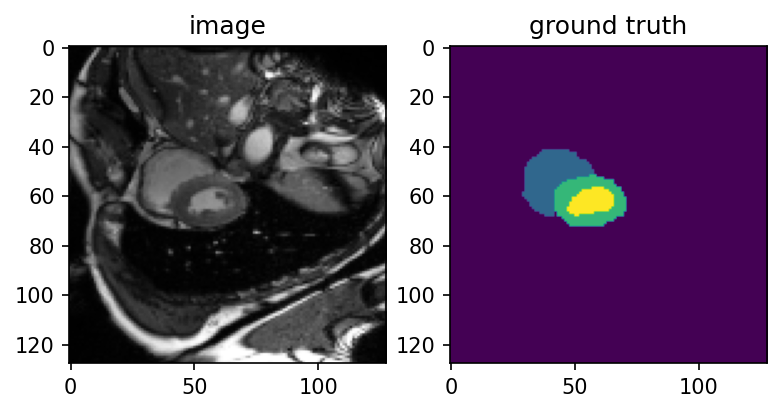

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

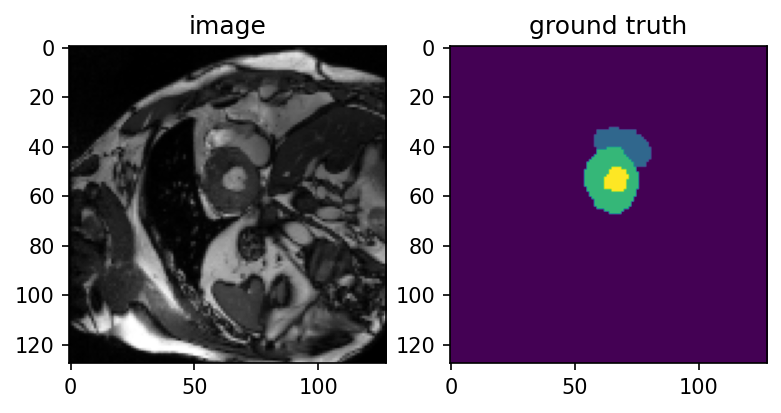

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

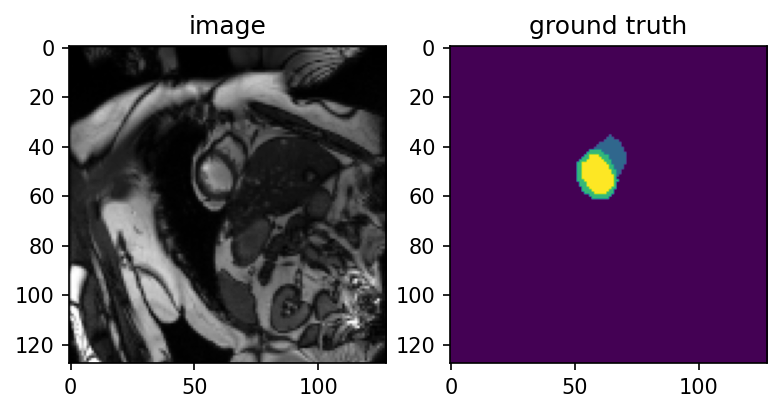

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

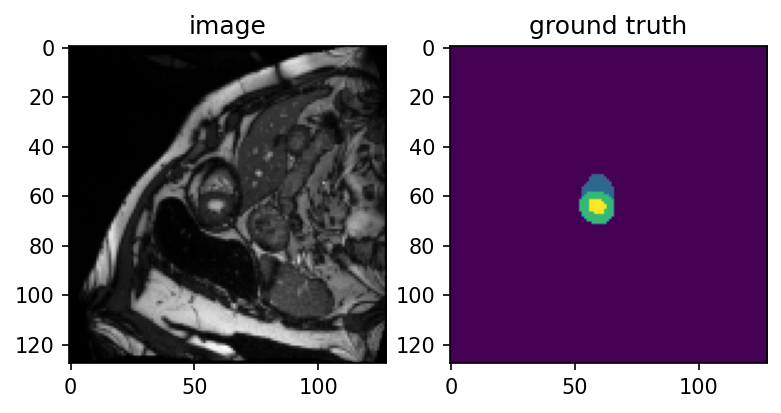

<IPython.core.display.Javascript object>

In [23]:
from google.colab import widgets

def plot(x, y, p=None, n=10):
    tb = widgets.TabBar([str(i) for i in range(len(x))][:n], location='top')
    for i in range(len(x))[:n]:
        image = x[i][...,0]
        truth = np.argmax(y[i], axis=-1)
        if p is not None: 
            prediction = np.argmax(p[i], axis=-1)
        with tb.output_to(i):
            if p is not None: fig, axs = plt.subplots(1,3)
            else:             fig, axs = plt.subplots(1,2)
            axs[0].imshow(image, cmap='Greys_r')
            axs[0].set_title('image')
            axs[1].imshow(truth, vmin=0, vmax=3)
            axs[1].set_title('ground truth')
            if p is not None:
                axs[2].imshow(prediction)
                axs[2].set_title('prediction')
            for ax in axs:
                ax.grid(False)

plot(X_train, Y_train)

# Define Network Topology

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [0]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, concatenate, AveragePooling2D
from tensorflow.keras.layers import UpSampling2D, BatchNormalization

channels_per_level = [32, 64, 128, 256]
bridge_channels = channels_per_level.pop()
identities = []
input_tensor = Input(shape=target_shape + (1,))
net = input_tensor

# encoder
for channels in channels_per_level:
    net = BatchNormalization(momentum=0.9)(net)
    net = Conv2D(channels, 3, padding='same', activation='relu')(net)
    identities.append(net)
    net = AveragePooling2D(padding='same')(net)

# bridge
net = BatchNormalization(momentum=0.9)(net)
net = Conv2D(bridge_channels, 3, padding='same', activation='relu')(net)

# decoder
for channels in channels_per_level[::-1]:
    net = UpSampling2D()(net)
    net = concatenate([net, identities.pop()])
    net = BatchNormalization(momentum=0.9)(net)
    net = Conv2D(channels, 3, padding='same', activation='relu')(net)

# classification
n_classes = Y_train[0].shape[-1]
net = Conv2D(n_classes, 1, padding='same', activation='sigmoid')(net)

# Create the Model

In [0]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model


#https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


learning_rate = 1e-3
model = Model(input_tensor, net)
model.compile(loss='binary_crossentropy',
              metrics=[dice_coef],
              optimizer=keras.optimizers.Adam(lr=learning_rate))

# Train the Model

In [20]:
model.fit(X_train, Y_train, 
          validation_data=[X_val, Y_val],
          epochs=3, batch_size=1)

Epoch 1/3
1711/1711 [==============================] - 29s 17ms/step - loss: 0.0082 - dice_coef: 0.9904 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 2/3
1711/1711 [==============================] - 29s 17ms/step - loss: 0.0079 - dice_coef: 0.9909 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 3/3
1711/1711 [==============================] - 29s 17ms/step - loss: 0.0067 - dice_coef: 0.9922 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00


In [21]:
predictions = []
for i in trange(len(X_val)):
    im = X_val[i]
    im = im.reshape((1,)+im.shape)
    prediction = model.predict(im)[0]
    predictions.append(prediction)
predictions = np.array(predictions)

100%|██████████| 191/191 [00:06<00:00, 29.41it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

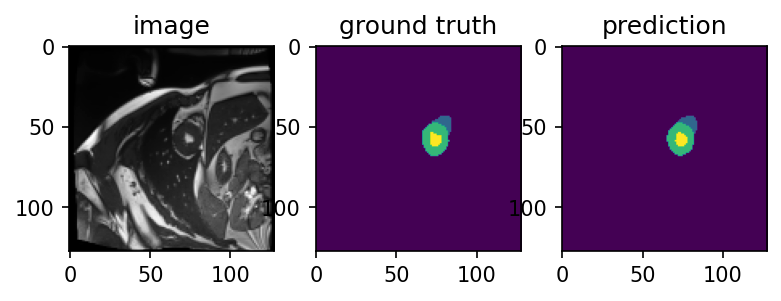

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

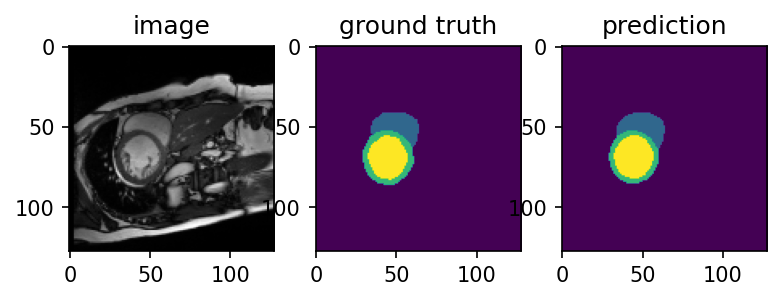

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

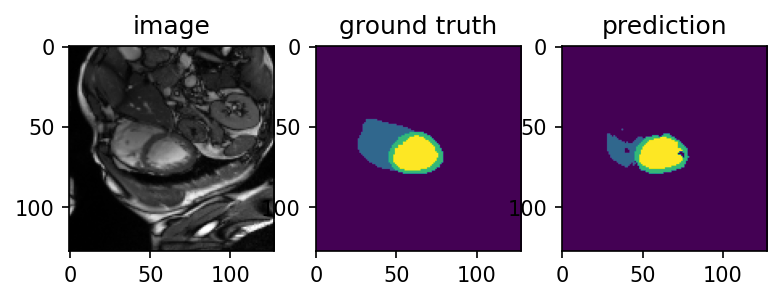

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

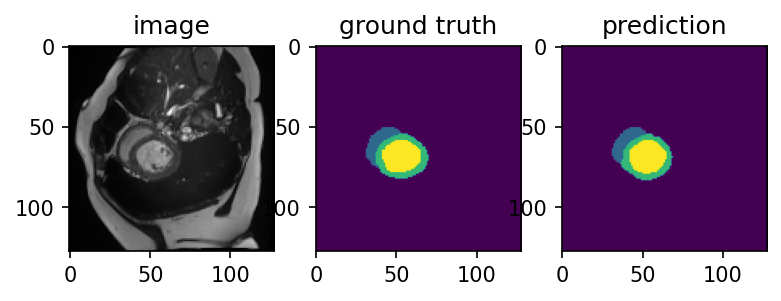

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

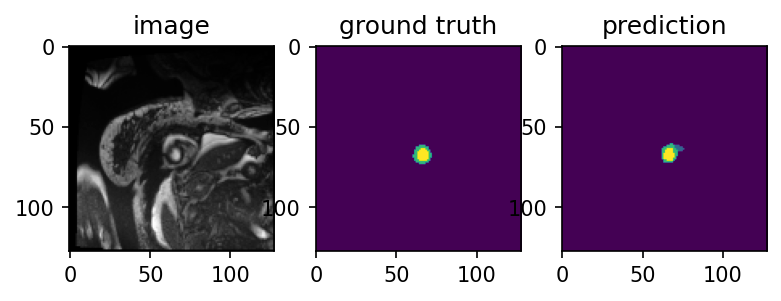

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

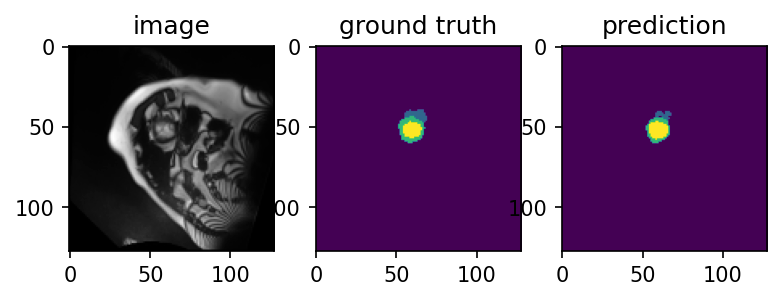

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

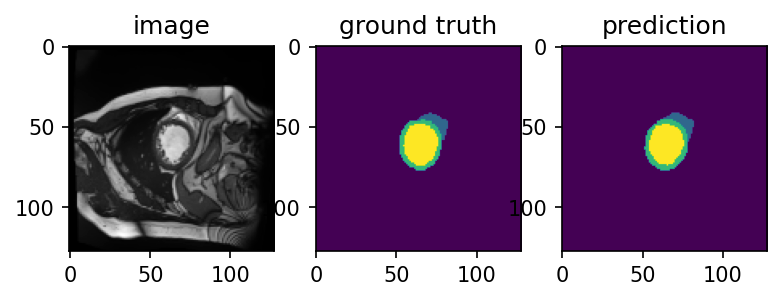

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

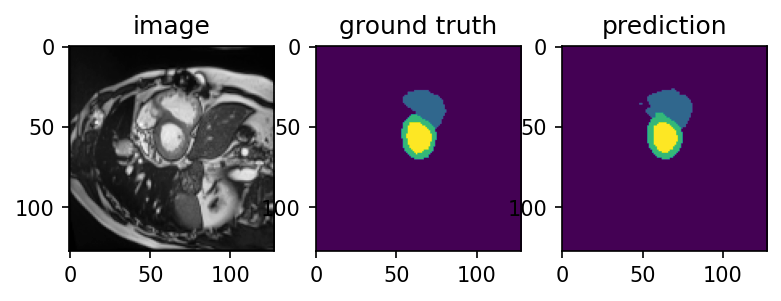

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

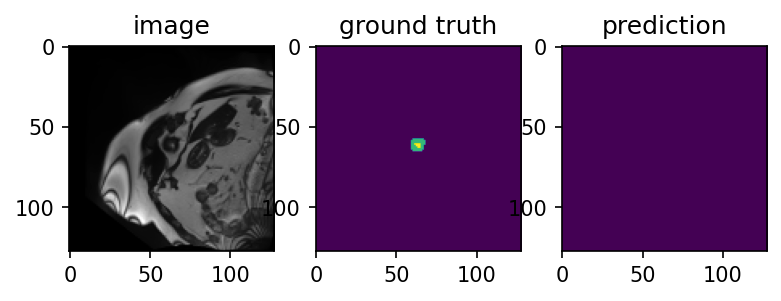

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

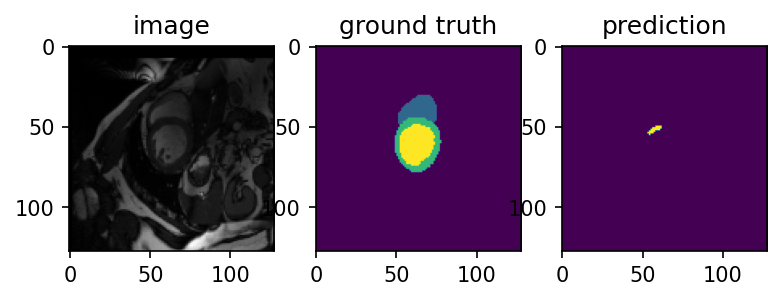

<IPython.core.display.Javascript object>

In [22]:
plot(X_val, Y_val, predictions)

# HANDS ON

## First
Examine the reproducibility of the results. Does the neural network always deliver the same performance?

## Second:
Identify the grave error in the setup of this experiment. To get a hint, hover over the light bulb symbol:  
![hint](https://upload.wikimedia.org/wikipedia/commons/f/fd/Oxygen480-actions-help-hint.svg "check for leakage in the train/validation split!")

## Third
Try to tune different hyperparameters: 
  - How does the input shape of the images impact training performance?
  - Does a deeper architecture yield better results?
  - How about a wider architecture?
  - Do more conv layers per down-/upsample step change the result?

## Fourth
Implement data augmentaion by mirroring the input data along both axis.